In [1]:
import scipy.ndimage as ndimage
import imageio
import numpy as np
import matplotlib.pyplot as plt

import cv2

# Read image and convert to grayscale

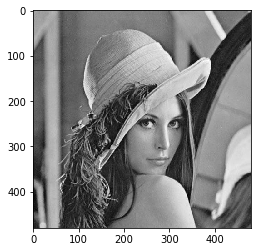

In [2]:
img_path = "image.jpg"

img = imageio.imread(img_path, as_gray=True)
plt.imshow(img, cmap='gray');

# Step 1. Apply gaussian filter to image with std = 1.4

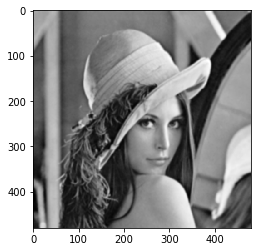

In [3]:
img = ndimage.gaussian_filter(img, sigma=1.4)
plt.imshow(img, cmap='gray')

# Step 2.1 Applying sobel filters to image to find gradients

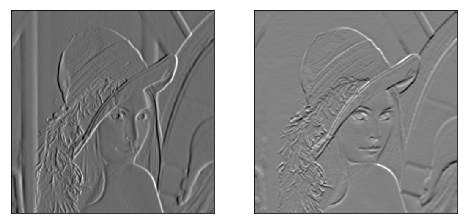

In [4]:
# We apply sobel filters to the image and find the
# gradients. 
sobel_v = np.array([
    [-1, 0, 1], 
    [-2, 0, 2], 
    [-1, 0, 1]])

Gx = ndimage.convolve(img, sobel_v)

sobel_h = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]])
Gy = ndimage.convolve(img, sobel_h)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(Gx, cmap='gray')

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(Gy, cmap='gray')

plt.show()

# Step 2.2 Finding the gradient magnitude and the orientation

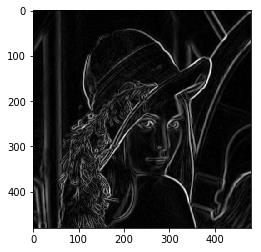

In [5]:
# We are finding the gradient magnitude and the
# gradient orientation. 
grad_magnitude = np.sqrt((Gx ** 2 + Gy ** 2) + 1e-8)
grad_angle = np.arctan2(Gy, Gx)

plt.imshow(grad_magnitude.astype(np.float32), cmap='gray')

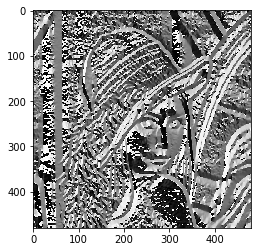

In [6]:
plt.imshow(grad_angle, cmap='gray')

# Step 3. Non-max supression

[Computerphile's Canny Edge Detector Algorithm Explanation](https://www.youtube.com/watch?v=sRFM5IEqR2w)

[Explanation](http://masters.donntu.org/2010/fknt/chudovskaja/library/article5.htm)

In [7]:
# In this step, we apply non-max supression. Firstly, we find the 
# direction of the gradients. It means that we are looking for the 
# which pixels to supress.

height, width = img.shape
supressed_image = np.zeros((height, width))

direction = np.rad2deg(grad_angle) % 180

ind_0 = ((0 <= direction) & (direction < 22.5)) | ((157.5 <= direction) & (direction < 180))
ind_45 = ((22.5 <= direction) & (direction < 67.5))
ind_90 = ((67.5 <= direction) & (direction < 112.5))
ind_135 = ((112.5 <= direction) & (direction < 157.5))

assert ind_0.mean() + ind_45.mean() + ind_90.mean() + ind_135.mean() == 1.0, \
        "There is something wrong with the indices"

grad_angle[ind_0] = 0
grad_angle[ind_45] = 45
grad_angle[ind_90] = 90
grad_angle[ind_135] = 135

# There is a reverse logic. Instead of setting 0 the pixel which is not
# the max of neighbors, we start with zeros matrix and fill with the 
# true value if it is the max of the neighbors.
for h in range(height):
    for w in range(width):
        try:
            if grad_angle[h, w] == 0:
                if grad_magnitude[h, w] >= grad_magnitude[h, w-1] and grad_magnitude[h, w] >= grad_magnitude[h, w+1]:
                    supressed_image[h, w] = grad_magnitude[h, w]
            elif grad_angle[h, w] == 45:
                if grad_magnitude[h, w] >= grad_magnitude[h-1, w+1] and grad_magnitude[h, w] >= grad_magnitude[h+1, w-1]:
                    supressed_image[h, w] = grad_magnitude[h, w]
            elif grad_angle[h, w] == 90:
                if grad_magnitude[h, w] >= grad_magnitude[h-1, w] and grad_magnitude[h, w] >= grad_magnitude[h+1, w]:
                    supressed_image[h, w] = grad_magnitude[h, w]
            elif grad_angle[h, w] == 135:
                if grad_magnitude[h, w] >= grad_magnitude[h-1, w-1] and grad_magnitude[h, w] >= grad_magnitude[h+1, w+1]:
                    supressed_image[h, w] = grad_magnitude[h, w]
                    
        except IndexError as e:
            pass

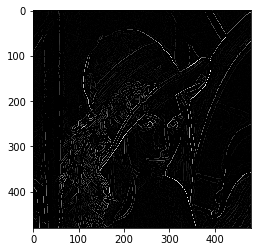

In [8]:
# Output of the non-max suprassion.
plt.imshow(supressed_image, cmap='gray');

# Step 4. Double Thresholding to find strong and weak edges

In [9]:
# We are finding the strong edges and the weak edges of the current image.
# We accept all the strong edges by default and deny all the pixels below 
# the low_threshold.
# For the pixels between the low_threshold and the high_threshold, we are
# looking the neighbors and if any adjacent pixel is strong edge, we mark 
# the current pixel as an edge. 

high_threshold = 90
low_threshold = supressed_image.mean()

strong_edges = supressed_image > high_threshold

thresholded_edges = np.array(strong_edges, dtype=np.uint8) + (supressed_image > low_threshold)
final_edges = strong_edges.copy()
current_pixels = []

for h in range(1, height-1):
    for w in range(1, width-1):
        if thresholded_edges[h, w] != 1:
            continue
            
        local_area = thresholded_edges[h-1: h+2, w-1: w+2]
        local_max = local_area.max()
        if local_max == 2:
            current_pixels.append((h, w))
            final_edges[h, w] = 1

# Step 5. Edge tracking by hysteresis

In [10]:
while len(current_pixels) > 0:
    new_pixels = []
    for h, w in current_pixels:
        for r in range(-1, 2):
            for c in range(-1, 2):
                if r == 0 and c == 0:
                    continue
                r2 = r + h
                c2 = c + w
                if r2 == height or c2 == width:
                    continue
                if thresholded_edges[r2, c2] == 1 and final_edges[r2, c2] == 0:
                    new_pixels.append((r2, c2))
                    final_edges[r2, c2] = 1
    
    current_pixels = new_pixels

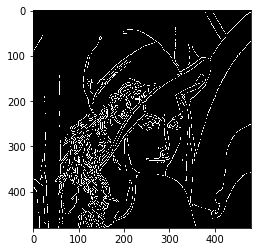

In [11]:
plt.imshow(final_edges, cmap='gray');

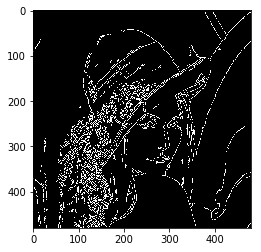

In [12]:
# Comparison with the opencv's Canny function.
# We used different threshold values here.

cv_img = cv2.imread(img_path)
plt.imshow(cv2.Canny(cv_img, 100, 200), cmap='gray')